In [14]:
#Importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torch._C import NoneType
import torch
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, log_loss, f1_score
import os
import h5py
from torchsummary import summary
from google.colab import files

In [7]:
dataframes_list = []
scaler = StandardScaler()

for i in range(1, 68):
    file_name = f"real_{i}.csv"
    df = pd.read_csv(file_name)
    df['value'] = scaler.fit_transform(df[['value']])
    dataframes_list.append(df)
combined_data = pd.concat(dataframes_list, ignore_index=True)
combined_data = combined_data.sample(frac=1).reset_index(drop=True)

In [8]:
display(combined_data)
combined_data.to_csv("combined_data.csv")

,timestamp,value,is_anomaly
0,523,-1.015228,0
1,592,-0.457730,0
2,1221,-0.532765,0
3,325,-0.099299,0
4,1329,-0.091048,0
...,...,...,...
94861,1137,-0.210639,0
94862,627,-1.351701,0
94863,1277,-0.105570,0
94864,64,-0.626422,0


#Summary

In [9]:
summary = combined_data.describe()
print(summary)
print(len(combined_data))

          timestamp         value    is_anomaly
count  94866.000000  9.486600e+04  94866.000000
mean     713.461883  5.213014e-17      0.017593
std      414.700963  1.000005e+00      0.131468
min        1.000000 -1.208575e+01      0.000000
25%      354.000000 -4.991567e-01      0.000000
50%      708.000000 -1.575523e-01      0.000000
75%     1072.000000  3.860517e-01      0.000000
max     1461.000000  3.614744e+01      1.000000
94866


#Data Cleaning

In [10]:
#handling null values
null_values = combined_data.isnull().sum()
print(null_values)

timestamp     0
value         0
is_anomaly    0
dtype: int64


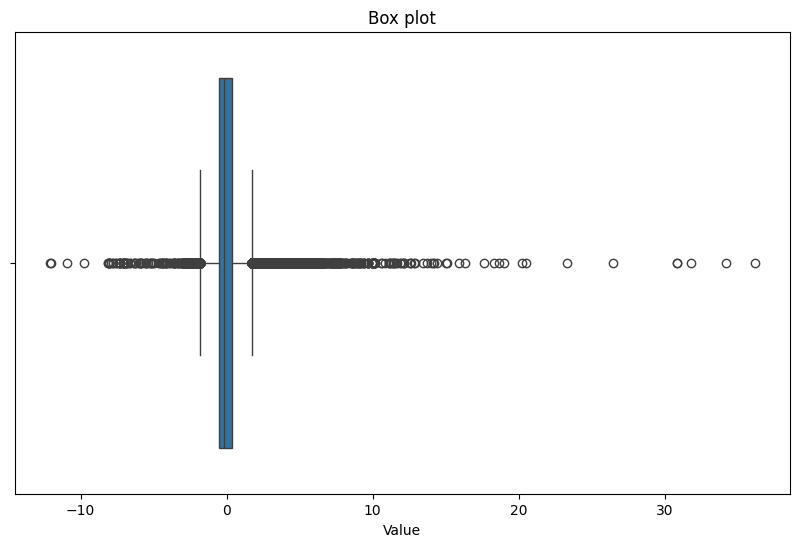

In [11]:
#replacing ourtliers

plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_data['value'])
plt.title('Box plot')
plt.xlabel('Value')
plt.show()

outl = combined_data['value'] > 15
median = combined_data.loc[~outl, 'value'].median()
combined_data.loc[outl, 'value'] = median

#Visualizations

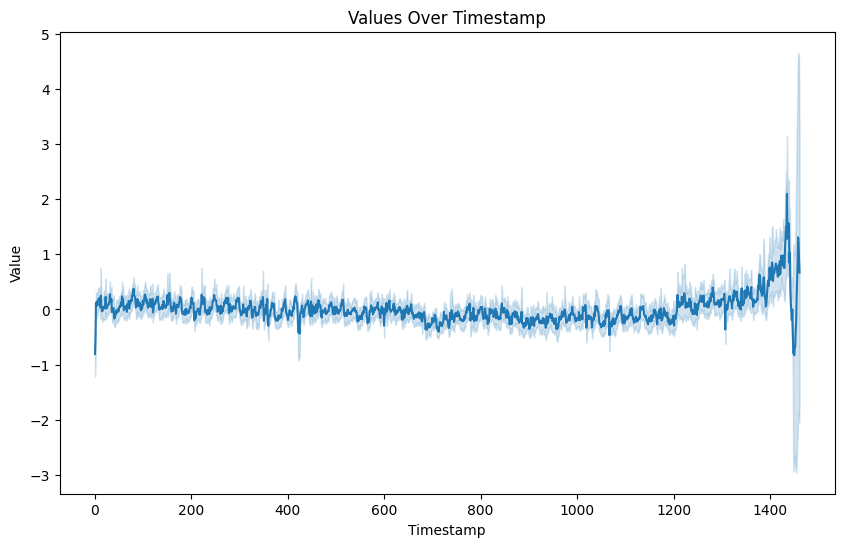

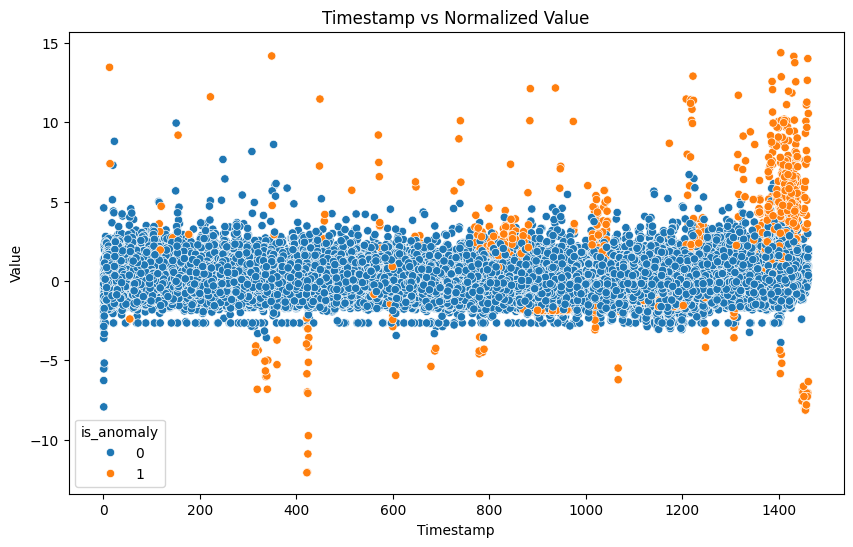

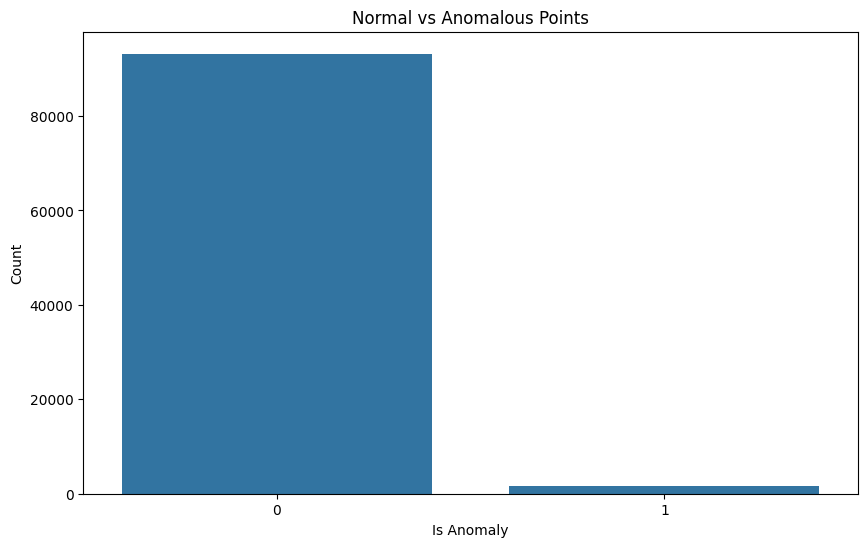

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=combined_data['timestamp'], y=combined_data['value'])
plt.title('Values Over Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=combined_data['timestamp'], y=combined_data['value'], hue=combined_data['is_anomaly'])
plt.title('Timestamp vs Normalized Value')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x=combined_data['is_anomaly'])
plt.title('Normal vs Anomalous Points')
plt.xlabel('Is Anomaly')
plt.ylabel('Count')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20, Train Loss: 0.1357509986560416, Val Loss: 0.0021765285796702723
Epoch 2/20, Train Loss: 0.0006089943299612606, Val Loss: 0.00037058641768677786
Epoch 3/20, Train Loss: 0.00011523905535944405, Val Loss: 9.976771736721075e-05
Epoch 4/20, Train Loss: 2.9156825757451065e-05, Val Loss: 2.6248001591265575e-05
Epoch 5/20, Train Loss: 9.298518037313977e-06, Val Loss: 1.3896389882045521e-05
Epoch 6/20, Train Loss: 5.05628960293452e-06, Val Loss: 9.19929342088203e-06
Epoch 7/20, Train Loss: 5.037079679180765e-06, Val Loss: 7.448281103189894e-06
Epoch 8/20, Train Loss: 5.628566959685505e-06, Val Loss: 1.0076090335796337e-05
Epoch 9/20, Train Loss: 2.4144438967102677e-06, Val Loss: 8.467086543809996e-06
Epoch 10/20, Train Loss: 6.006554156142035e-06, Val Loss: 9.570420931997623e-06
Epoch 11/20, Train Loss: 4.379452100699358e-06, Val Loss: 9.328537437917077e-06
Epoch 12/20, Train Loss: 5.540218863153653e-06, Val Loss: 8.318969826574762e-06
Epoch 13/20, Train Loss: 4.334499668509021e-06,

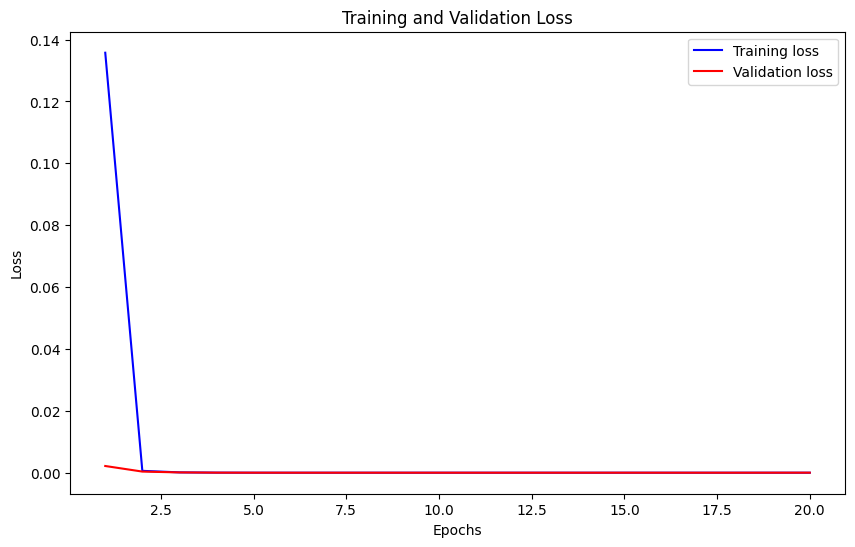

Test Loss: 0.0001588909382153317


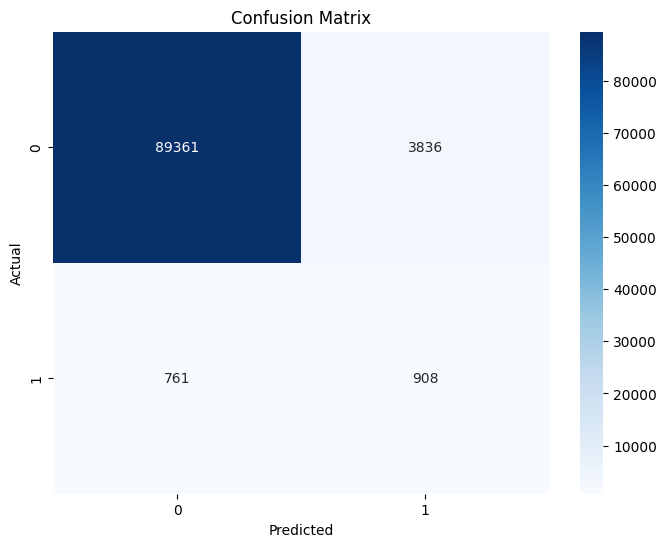

Accuracy: 0.9515421752788144, Precision: 0.19139966273187184, Recall: 0.5440383463151588, F1 Score: 0.2831748011850928


In [15]:
#standard autoencoder

def prepare_data(combined_data, batch_size=64, test_size=0.2):
    normal_data = combined_data[combined_data['is_anomaly'] == 0]
    all_data = combined_data
    scaler = StandardScaler()

    normal_feat = scaler.fit_transform(normal_data[['timestamp', 'value']].values.astype(np.float32))
    all_feat = scaler.transform(all_data[['timestamp', 'value']].values.astype(np.float32))
    all_labels = all_data['is_anomaly'].values.astype(np.float32)

    X_train, X_val, _, _ = train_test_split(normal_feat, np.zeros(len(normal_feat)), test_size=test_size, random_state=42)
    X_test = all_feat
    y_test = all_labels

    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.zeros(len(X_train)))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.zeros(len(X_val)))
    test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, y_test

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def model_save(model, filepath='model_weights.h5'):
    state_dict = model.state_dict()
    with h5py.File(filepath, 'w') as h5f:
        for k, v in state_dict.items():
            h5f.create_dataset(k, data=v.cpu().numpy())

def train_fun(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_los_list = []
    val_los_list = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for data in train_loader:
            inputs = data[0].float()
            optimizer.zero_grad()
            reconst = model(inputs)
            loss = criterion(reconst, inputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        train_los_list.append(average_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs = data[0].float()
                reconst = model(inputs)
                loss = criterion(reconst, inputs)
                total_val_loss += loss.item()
        average_val_loss = total_val_loss / len(val_loader)
        val_los_list.append(average_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Val Loss: {average_val_loss}')

    return train_los_list, val_los_list

def test_plot(model, test_loader, y_test):
    model.eval()
    test_reconst_errors = []
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.float()
            outputs = model(inputs)
            loss = torch.mean((inputs - outputs) ** 2, dim=1)
            reconst_errors = loss.numpy()
            test_reconst_errors.extend(reconst_errors)
            total_test_loss += loss.sum().item()

    average_test_loss = total_test_loss / len(test_loader.dataset)
    print(f'Test Loss: {average_test_loss}')

    threshold = np.percentile(test_reconst_errors, 95)
    predictions = (np.array(test_reconst_errors) > threshold).astype(int)

    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_loader, val_loader, test_loader, y_test = prepare_data(combined_data)


model = Autoencoder()
model_save(model, 'autoencoder_weights.h5')
files.download('autoencoder_weights.h5')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_los_list, val_los_list = train_fun(model, criterion, optimizer, train_loader, val_loader, 20)
plot_loss(train_los_list, val_los_list)
test_plot(model, test_loader, y_test)




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20, Train Loss: 0.6700407134361022, Val Loss: 0.5580139825605366
Epoch 2/20, Train Loss: 0.5491707945330461, Val Loss: 0.5549001373248558
Epoch 3/20, Train Loss: 0.5478572613435754, Val Loss: 0.5543259123008545
Epoch 4/20, Train Loss: 0.5475924952603205, Val Loss: 0.5542220037481557
Epoch 5/20, Train Loss: 0.5475346875804689, Val Loss: 0.554221993439818
Epoch 6/20, Train Loss: 0.5474810588257507, Val Loss: 0.5541625789379421
Epoch 7/20, Train Loss: 0.5474582715607508, Val Loss: 0.5541564165933491
Epoch 8/20, Train Loss: 0.547408592624214, Val Loss: 0.5541541551890439
Epoch 9/20, Train Loss: 0.5474155504048638, Val Loss: 0.5542245689932614
Epoch 10/20, Train Loss: 0.5473862974173009, Val Loss: 0.5541812980624095
Epoch 11/20, Train Loss: 0.5474084496753922, Val Loss: 0.5540933706989027
Epoch 12/20, Train Loss: 0.5473662667264243, Val Loss: 0.5541070073026501
Epoch 13/20, Train Loss: 0.5473548474485782, Val Loss: 0.5540795106798002
Epoch 14/20, Train Loss: 0.5473076536675892, Val 

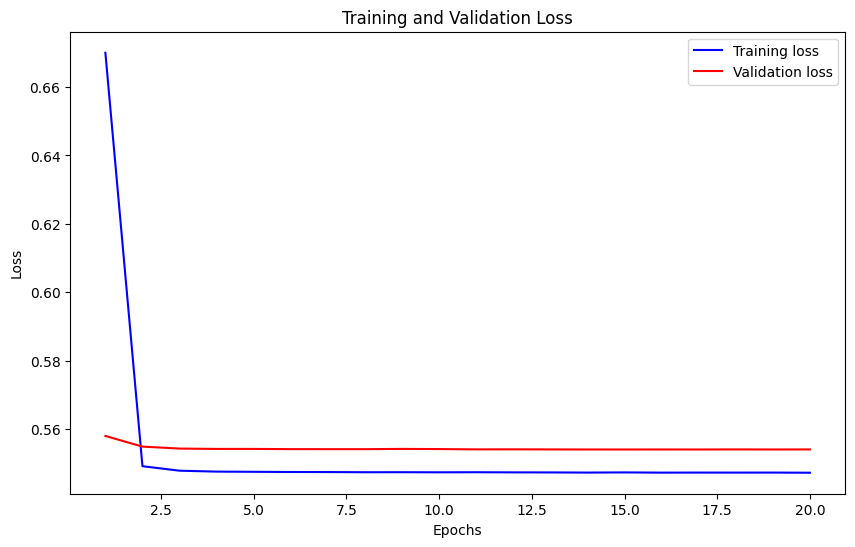

Test Loss: 0.7018381513690842


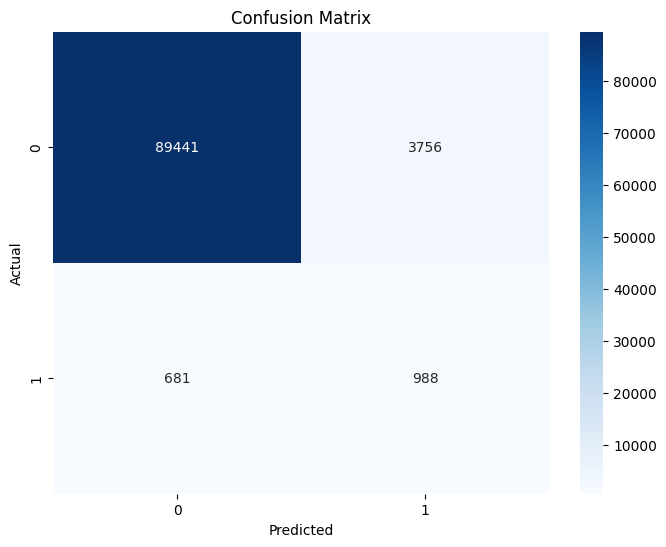

Accuracy: 0.9532287647840111, Precision: 0.20826306913996628, Recall: 0.5919712402636309, F1 Score: 0.30812412287540936


In [16]:
#Dense Autoencoder Variation 1
class dense_autoencoder(nn.Module):
    def __init__(self):
        super(dense_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 4),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

train_loader, val_loader, test_loader, y_test = prepare_data(combined_data)
model = dense_autoencoder()
model_save(model, 'dense_autoencoder_weights.h5')
files.download('dense_autoencoder_weights.h5')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_los_list, val_los_list = train_fun(model, criterion, optimizer, train_loader, val_loader,20)
plot_loss(train_los_list, val_los_list)
test_plot(model, test_loader, y_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20, Train Loss: 0.5740169948006905, Val Loss: 0.5570168219608803
Epoch 2/20, Train Loss: 0.5504758289443576, Val Loss: 0.5550410208636767
Epoch 3/20, Train Loss: 0.5495373340379527, Val Loss: 0.5550834493686075
Epoch 4/20, Train Loss: 0.5489513296170296, Val Loss: 0.55502526421253
Epoch 5/20, Train Loss: 0.5490605155285847, Val Loss: 0.555834310205832
Epoch 6/20, Train Loss: 0.5487637259162035, Val Loss: 0.5551311567629853
Epoch 7/20, Train Loss: 0.5483238408493893, Val Loss: 0.554940621534439
Epoch 8/20, Train Loss: 0.548208107943187, Val Loss: 0.5548069231110077
Epoch 9/20, Train Loss: 0.548192135586759, Val Loss: 0.5544567650107488
Epoch 10/20, Train Loss: 0.5480262933115079, Val Loss: 0.554438831055001
Epoch 11/20, Train Loss: 0.548037748556792, Val Loss: 0.5544760120037484
Epoch 12/20, Train Loss: 0.5479466895432943, Val Loss: 0.5544155394173649
Epoch 13/20, Train Loss: 0.5478635638568534, Val Loss: 0.5545390754529874
Epoch 14/20, Train Loss: 0.5477957717850485, Val Loss: 

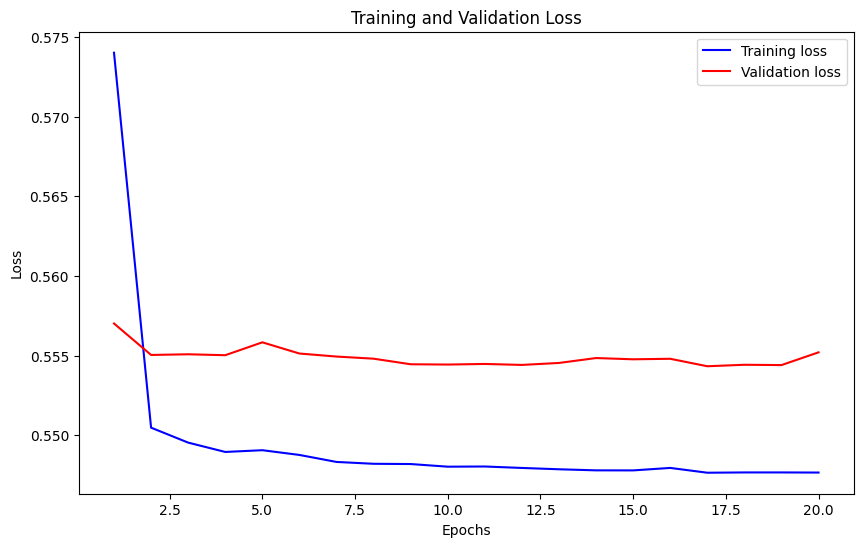

Test Loss: 0.7030277971479172


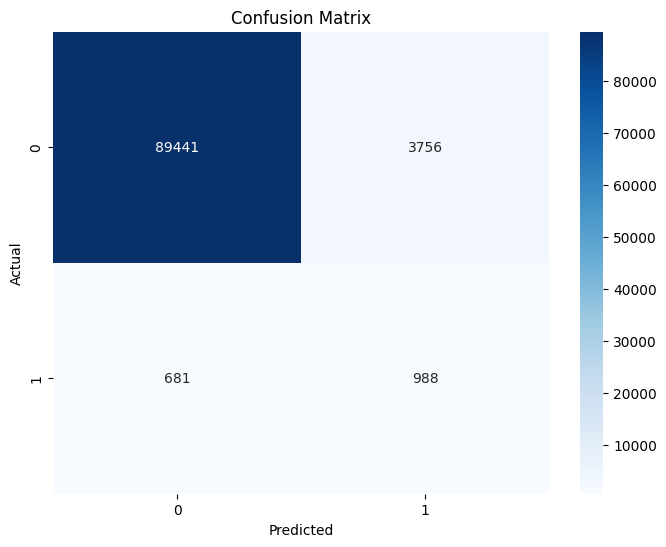

Accuracy: 0.9532287647840111, Precision: 0.20826306913996628, Recall: 0.5919712402636309, F1 Score: 0.30812412287540936


In [17]:
#Dense Autoencoder Variation 2

class dense_autoencoder2(nn.Module):
    def __init__(self):
        super(dense_autoencoder2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(), nn.BatchNorm1d(32),
            nn.Linear(32, 64), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Linear(64, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Linear(64, 32), nn.ReLU(), nn.BatchNorm1d(32),
            nn.Linear(32, 16), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), nn.ReLU(), nn.BatchNorm1d(32),
            nn.Linear(32, 64), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Linear(64, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Linear(64, 32), nn.ReLU(), nn.BatchNorm1d(32),
            nn.Linear(32, 2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

train_loader, val_loader, test_loader, y_test = prepare_data(combined_data)
model = dense_autoencoder2()
model_save(model, 'dense_autoencoder_weights2.h5')
files.download('dense_autoencoder_weights2.h5')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_los_list, val_los_list = train_fun(model, criterion, optimizer, train_loader, val_loader, 20)
plot_loss(train_los_list, val_los_list)
test_plot(model, test_loader, y_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 10, 1])) that is different to the input size (torch.Size([64, 10, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([44, 10, 1])) that is different to the input size (torch.Size([44, 10, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28, 10, 1])) that is different to the input size (torch.Size([28, 10, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same

Epoch 1/20, Train Loss: 0.6475868898790964, Val Loss: 0.572247129096728
Epoch 2/20, Train Loss: 0.5629888311857719, Val Loss: 0.5342145500961779
Epoch 3/20, Train Loss: 0.5508553236220377, Val Loss: 0.544351030479778
Epoch 4/20, Train Loss: 0.5429144325284492, Val Loss: 0.5334448927781398
Epoch 5/20, Train Loss: 0.544743952848658, Val Loss: 0.5714541714801531
Epoch 6/20, Train Loss: 0.5472052483293298, Val Loss: 0.5304700756313825
Epoch 7/20, Train Loss: 0.5410784575051643, Val Loss: 0.520828930516837
Epoch 8/20, Train Loss: 0.5273173699441286, Val Loss: 0.5171647121007193
Epoch 9/20, Train Loss: 0.5254631342513967, Val Loss: 0.5124901343977412
Epoch 10/20, Train Loss: 0.5288626703026926, Val Loss: 0.5238975815299384
Epoch 11/20, Train Loss: 0.5238021060472596, Val Loss: 0.5101414414166602
Epoch 12/20, Train Loss: 0.5304075395955404, Val Loss: 0.5503637042109814
Epoch 13/20, Train Loss: 0.5459612785362674, Val Loss: 0.5515057964357062
Epoch 14/20, Train Loss: 0.5611526229329294, Val Lo

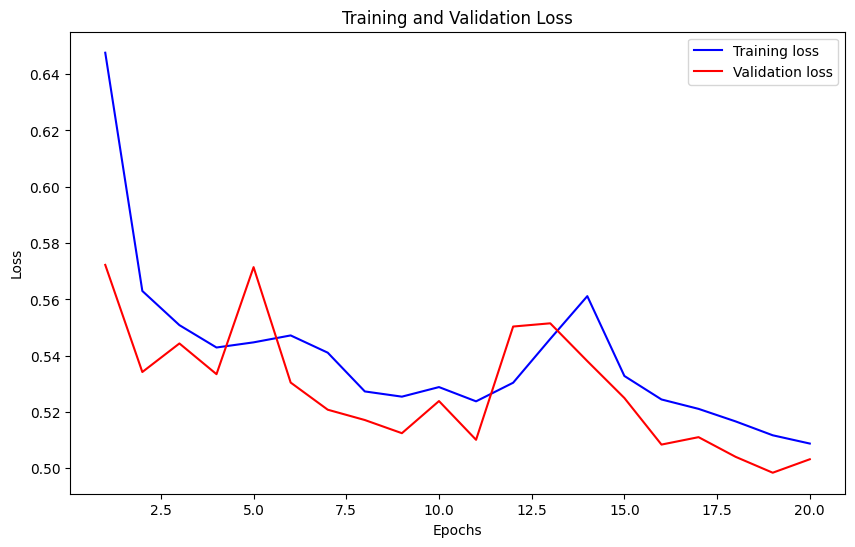

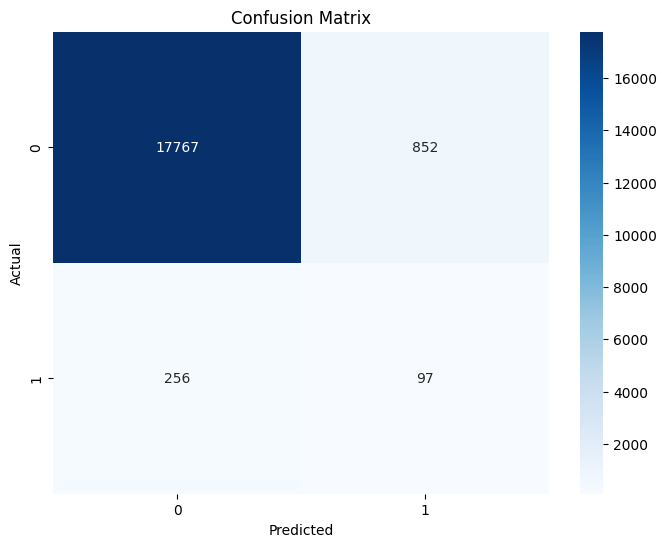

Average Test Loss: 0.5037
Accuracy: 0.9415981446341978, Precision: 0.10221285563751317, Recall: 0.2747875354107649, F1 Score: 0.1490015360983103


In [18]:
#LSTM autoencoder
def prepare_data_lstm(combined_data, seql=10, batch_size=64, test_size=0.2):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(combined_data[['value']].values.astype(np.float32))

    seq = []
    labels = []
    for i in range(len(data_scaled) - seql):
        temp_seq = data_scaled[i:i+seql]
        label = combined_data['is_anomaly'].iloc[i+seql-1]
        seq.append(temp_seq)
        labels.append(label)

    seq = np.array(seq)
    labels = np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(seq, labels, test_size=test_size, random_state=42)
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, test_loader, y_test

class lstm_autoencoder(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, seql=10):
        super(lstm_autoencoder, self).__init__()
        self.seql = seql
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.encoder_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.encoder_linear = nn.Linear(hidden_size * seql, 4)
        self.decoder_linear = nn.Linear(4, hidden_size * seql)
        self.decoder_lstm = nn.LSTM(input_size=hidden_size, hidden_size=input_size, batch_first=True)
    def forward(self, x):
        x, (hn, cn) = self.encoder_lstm(x)
        x = x.reshape(x.shape[0], -1)
        x = self.encoder_linear(x)
        x = self.decoder_linear(x)
        x = x.reshape(x.shape[0], self.seql, self.hidden_size)
        x, (hn, cn) = self.decoder_lstm(x)
        return x

def test_plot_lstm(model, test_loader, y_test):
    model.eval()
    test_reconst_errors = []
    total_test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            inputs = data.float()
            outputs = model(inputs)
            loss = torch.mean((inputs - outputs) ** 2, dim=[1, 2])
            total_test_loss += loss.sum().item()
            reconst_errors = loss.cpu().numpy()
            test_reconst_errors.extend(reconst_errors)

    average_test_loss = total_test_loss / len(test_loader.dataset)

    threshold = np.percentile(test_reconst_errors, 95)
    predictions = np.array([1 if error > threshold else 0 for error in test_reconst_errors])
    y_test = np.array(y_test).flatten()

    cm = confusion_matrix(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Average Test Loss: {average_test_loss:.4f}')
    print(f'Accuracy: {(cm[0][0] + cm[1][1]) / np.sum(cm)}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')


train_loader, val_loader, test_loader, y_test = prepare_data_lstm(combined_data, 10, 64, 0.2)
model = lstm_autoencoder(input_size=2, hidden_size=64, seql=10)
model_save(model, 'lstm_autoencoder_weights.h5')
files.download('lstm_autoencoder_weights.h5')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_los_list, val_los_list = train_fun(model, criterion, optimizer, train_loader, val_loader, 20)
plot_loss(train_los_list, val_los_list)
test_plot_lstm(model, test_loader, y_test)